# Importing the goodies

In [3]:
from tqdm import tnrange, tqdm_notebook
import numpy as np
from numpy import moveaxis
import torch
from torch.utils.data.sampler import Sampler
from torch.utils.data import TensorDataset 
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn                                                
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
import time
from sklearn.metrics import confusion_matrix
import itertools
import cv2

# Parallel CNNs

Two models having intentionally different architectures leads to them having different confusion matrices (i.e different weak areas when classifying). But when the 2 models are combined using a third class wrapper and a few more linear layers, they tend to neutralise each other’s weaknesses

<img src= "parallel_cnn.jpg" />

### Pros of using this technique are:
* By combining the strengths of two different CNNs. We can make a robust model that can learn from two different versions of the same image (as seen in figure 6).
* High accuracy with a relatively small architecture.


# Loading up training data 
* they're the same training data as use in c_elegans_lifecycle.ipynb
* arrays with the _smol suffix have 120 * 90 images
* the bigger array has 480 * 360 images, much heavier on the GPU
* `np_arr_to_canny_edges()` returns a numpy array that runs through the canny edge detector

In [0]:
def load_numpy_arrays(paths_list):
    s = []
    for i in paths_list:
        s.append(np.array(np.load( i , allow_pickle = True)))
    arr = np.vstack(tuple(j for j in s))
    del s
    return arr

## cv2 canny thing 
def np_arr_to_canny_edges(im_arr):
    ed = cv2.Canny(im_arr.astype(np.uint8), 100,100)
    return ed

def view_samples_from_training_data(arr, skip_val, canny = False):
    images = []
    for i in range (0,len(arr), skip_val):
        foo = arr[i][0]
        if canny == True:
            foo = np_arr_to_canny_edges(foo)
        images.append(foo)
    f = plt.figure(figsize = (35,20))
    for m in range (1,len(images)):
        f.add_subplot(1,len(images), m)
        if canny == True:

            plt.imshow(images[m], cmap = "gist_earth", label = "Canny")
            plt.xlabel("Canny edge detection", fontsize = 22)
        else:
            plt.imshow(images[m], cmap = "gist_earth")
            plt.xlabel("Original image", fontsize = 22)

    plt.show()

In [0]:
smol_paths = [
            ROOT + "numpy/gastrula_smol.npy",
            ROOT + "numpy/comma_smol.npy",
            ROOT + "numpy/fold_smol.npy", 
            ROOT + "numpy/l1_smol.npy"
              ]

big_paths = [
            ROOT + "numpy/gastrula.npy",
            ROOT + "numpy/comma.npy",
            ROOT + "numpy/fold.npy", 
            ROOT + "numpy/l1.npy"
            ]
arr_smol = load_numpy_arrays(smol_paths)
arr_big = load_numpy_arrays(big_paths)


## Viewing the two versions of the training data
* row 2 contains the same images but after running them through `cv2.Canny()`

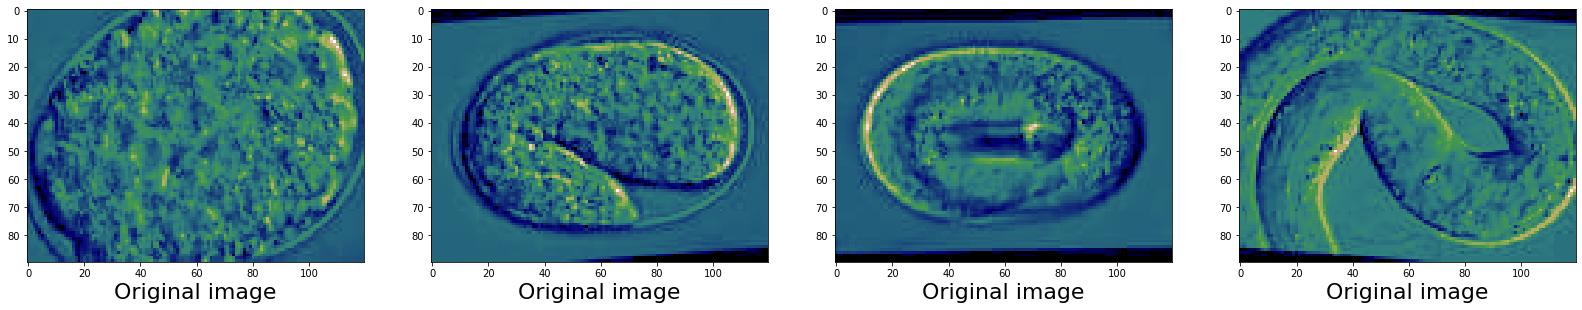

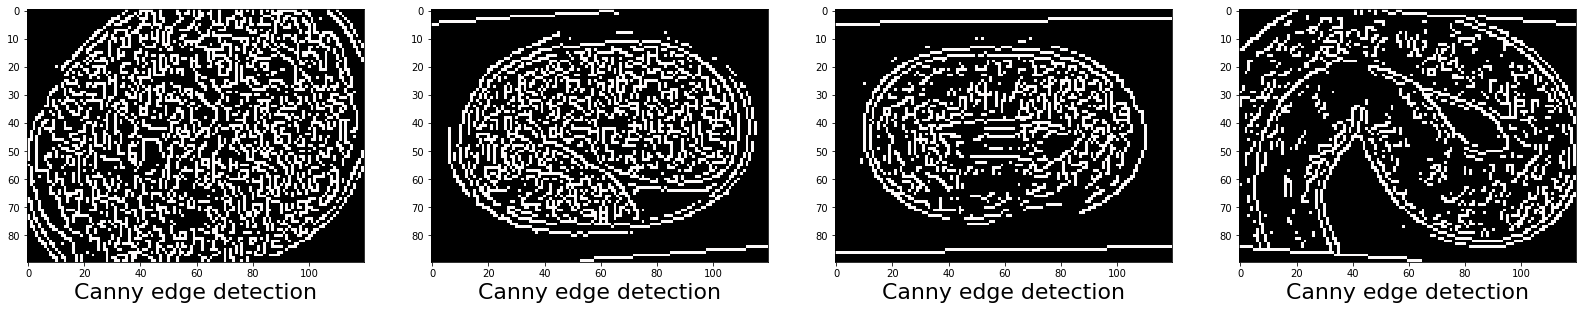

In [218]:
view_samples_from_training_data(arr_smol, 1488)
view_samples_from_training_data(arr_smol, 1488, canny = True)

## Converting the loaded arrays to torch.utils.data.DataLoader() and some other utils
* `plot_confusion_matrix()` takes in the 2d confusion matrix as input and plots a fancy looking confusion matrix
* `confusion_matrix_finder()` - returns the confusion matrix of a model on a given test set

In [0]:
def extract_column(arr, index):
    x_train = []
    for m in range (len(arr)):
        x_train.append(arr[m][index])
    return(np.array(x_train))

def batch_to_canny(tensor_batch):
    batch = []
    tensor_batch = tensor_batch.view(-1,tensor_batch.size()[-2], tensor_batch.size()[-1] )
    for image in tensor_batch:

        foo = (image.numpy().astype(np.uint8))
        ed = np_arr_to_canny_edges(foo)
        batch.append(ed)

    foo = torch.Tensor(batch)
    foo = foo.view(-1,1, foo.size()[1], foo.size()[2])
    return foo


def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize=15)
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()


def preprocess_to_tensors_for_training(np_array, batch_size, val_batch_size):

    x_train = extract_column(np_array,0)
    y_train = extract_column(np_array,1)
    x_train_tensor = torch.from_numpy(x_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    full_dataset = TensorDataset(x_train_tensor, y_train_tensor)    ## make compatible with DataLoader 
    train_size = int(0.8 * len(full_dataset))  ## 90/10 split
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=test_dataset, batch_size=val_batch_size, shuffle = True)
    print(len(train_loader), "batches ")
    print(len(val_loader), " batches ")

    return train_loader, val_loader


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(7,7))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize = 23)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def confusion_matrix_finder(cellnet, val_loader, combined = False):
    y_true = []
    y_pred = []
    cellnet.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        
        for batch in val_loader:
            x_val, y_val = batch
            x_val = x_val.view(-1, 1, x_val.size()[1], x_val.size()[2]) 
            if combined == True:
                pred = cellnet(x_val, x_val)  # pred
            else:
                pred = cellnet(x_val)  # pred
            y_pred.extend(torch.argmax(pred,dim = 1).float().numpy().flatten())
            y_true.extend(y_val.numpy().flatten())
        return y_true, y_pred


In [39]:

train_loader_smol, val_loader_smol = preprocess_to_tensors_for_training(arr_smol, 36, 9)
train_loader_big, val_loader_big = preprocess_to_tensors_for_training(arr_big, 12, 3)

134 batches 
134  batches 
134 batches 
134  batches 


##  Defining the training and the testing loops for the single and the combined network(s)
* functions ending with the  `_combined()` suffix are meant for the combined CNN with two smaller but different architectures in parallel with the same input
> the combined CNN takes input as `combined_model(x,x)` instead of te regular `model(x)`, this was done so that it can be scaled later on to take in two different pictures as input.

In [0]:
def calculate_accuracy_on_validation_set(val_loader, cellnet):
    
    cellnet.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in val_loader:
            x_val, y_val = batch
            x_val = x_val.view(-1, 1, x_val.size()[1], x_val.size()[2])        # if torch tensor
            pred = cellnet(x_val)  # pred()
            scores = ([i.item() for i in (torch.eq(torch.argmax(pred,dim = 1).float(), y_val))])
            for m in scores:
                total+= 1 
                if m == True:
                    correct +=1 
        acc = (correct/total)*100
        return acc

def calculate_accuracy_combined_model(val_loader, cellnet):
    print("running benchmark...")
    with torch.no_grad():
        total = 0
        correct = 0
        for x_val, y_val in val_loader:
            total+= 1 
            x_val = x_val.view(-1, 1, x_val.size()[1], x_val.size()[2])   
            y_val =  y_val.long()
            pred = cellnet(x_val, x_val)  # pred 
            scores = ([i.item() for i in (torch.eq(torch.argmax(pred,dim = 1).float(), y_val))])
            for m in scores:
                total+= 1 
                if m == True:
                    correct +=1 
        acc = (correct/total)*100
        return acc
    

def train_step(x, y, cellnet, optimizer):
        optimizer.zero_grad()
        x = x.view(-1, 1, x.size()[1], x.size()[2])        # if torch tensor
        pred = cellnet(x)
        y = y.long()
        loss = F.cross_entropy(pred,y)
        loss.backward()
        optimizer.step()        
        return loss.item()

def train(cellnet, epochs, train_loader, val_loader, optimizer):
    start = time.process_time()
    losses = []
    val_losses = []
    times = []
    timed_val_losses = []

    for m in range (epochs):
        clear_output()
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in val_loader:
                y_val =  y_val.long()
                x_val = x_val.view(-1, 1, x_val.size()[1], x_val.size()[2])        # if torch tensor
                yhat =cellnet(x_val)  # pred 
                val_loss = F.cross_entropy(yhat, y_val)
                val_losses.append(val_loss.item())  ## metrics 
                
                timed_val_losses.append(val_loss.item())
                times.append(time.process_time()- start)
        cellnet.train()
        
        for x_batch, y_batch in tqdm_notebook(train_loader, desc = " Training batches : "):
                loss = train_step(x_batch, y_batch, cellnet, optimizer)
                losses.append(loss)
        scheduler.step()   ## lr decay caller 

    clear_output()
    vis_loss_multi_colors(losses, val_losses)
    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses, val_losses

   
def train_step_combined(x, y, model, optimizer):
        optimizer.zero_grad()
        x = x.view(-1, 1, x.size()[1], x.size()[2])        # if torch tensor
        pred = model(x,x)
        y = y.long()
        loss = F.cross_entropy(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()

def train_combined_model(epochs, cellnet, optimizer, train_loader, val_loader):
    start = time.process_time()
    losses = []
    val_losses = []

    for m in range (epochs):
        clear_output()
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            cellnet.eval()

            for x_val, y_val in val_loader:
                y_val =  y_val.long()
                x_val = x_val.view(-1, 1, x_val.size()[1], x_val.size()[2])        # if torch tensor
                yhat =cellnet(x_val, x_val)  # pred 
                val_loss = F.cross_entropy(yhat, y_val)
                val_losses.append(val_loss.item())  ## metrics 
        cellnet.train()
        for x_batch, y_batch in tqdm_notebook(train_loader, desc = " Training batches : "):
                loss = train_step_combined(x_batch, y_batch, cellnet, optimizer)
                losses.append(loss)
        scheduler.step()   ## lr decay caller 

    clear_output()
    vis_loss_multi_colors(losses, val_losses)
    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses, val_losses


## Building two small CNNs 
* `cellnet_1()` is a relatively wider and shallower network as compared to `cellnet_2()`
* Both of them have different kernel sizes as well
> This was intentionallly done in order to obtain two differrent confusion matrices

In [177]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(5,5)

        self.pool2 = nn.MaxPool2d(3,3)
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(10, 10, 3)
        self.conv3 = nn.Conv2d(10, 10, 3)
        
        self.fc1 = nn.Linear(150, 110)
        self.fc2 = nn.Linear(110, 100)
        self.fc3 = nn.Linear(100, 4)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = (self.fc3(x))      ## removed relu
        return x

cellnet_1 = Net()
optimizer = optim.Adam(cellnet_1.parameters(), lr = 0.001) 
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)  # lr decreases by 1% aftr every epoch
summary(cellnet_1,(1,120,90))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 10, 118, 88]             100
         MaxPool2d-2           [-1, 10, 23, 17]               0
            Conv2d-3           [-1, 10, 21, 15]             910
         MaxPool2d-4             [-1, 10, 7, 5]               0
            Conv2d-5             [-1, 10, 5, 3]             910
            Linear-6                  [-1, 110]          16,610
            Linear-7                  [-1, 100]          11,100
            Linear-8                    [-1, 4]             404
Total params: 30,034
Trainable params: 30,034
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.85
Params size (MB): 0.11
Estimated Total Size (MB): 1.01
----------------------------------------------------------------


In [189]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.pool = nn.MaxPool2d(3,3)
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(4, 8, 5)

        self.fc1 = nn.Linear(704,200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 20)

        self.fc4 = nn.Linear(20, 4)

    def forward(self, x):
        x = batch_to_canny(x)
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = (self.fc4(x))      ## removed relu
        return x

cellnet_2 = Net_2()
optimizer_2 = optim.Adam(cellnet_2.parameters(), lr = 0.001) 
scheduler = StepLR(optimizer_2, step_size=1, gamma=0.99)  # lr decreases by 1% aftr every epoch
summary(cellnet_2,(1,120,90))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 116, 86]             104
         MaxPool2d-2            [-1, 4, 38, 28]               0
            Conv2d-3            [-1, 8, 34, 24]             808
         MaxPool2d-4             [-1, 8, 11, 8]               0
            Linear-5                  [-1, 200]         141,000
            Linear-6                   [-1, 50]          10,050
            Linear-7                   [-1, 20]           1,020
            Linear-8                    [-1, 4]              84
Total params: 153,066
Trainable params: 153,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.39
Params size (MB): 0.58
Estimated Total Size (MB): 1.02
----------------------------------------------------------------


# Training the two smaller architectures for a few epochs and saving them
* both the models peak at an accuracy of about 95 %

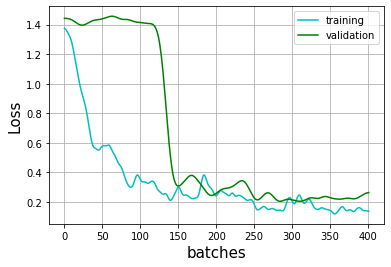

Time elapsed =  48.548912334999955  seconds


In [180]:
losses, val_losses = train(cellnet_1, 3, train_loader_smol, val_loader_smol, optimizer)

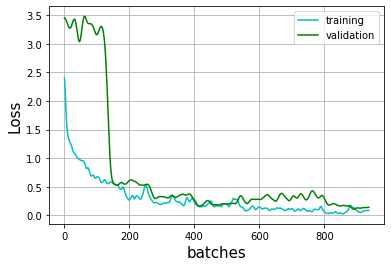

Time elapsed =  168.42308948100003  seconds


In [190]:
losses_2, val_losses_2 = train(cellnet_2, 7, train_loader_smol, val_loader_smol, optimizer_2)

In [0]:
torch.save(cellnet_1.state_dict(), "cellnet_1.pt")
torch.save(cellnet_2.state_dict(), "cellnet_2.pt")

## Defining a new class which wraps the other two trained CNNs
* The `forward()` of this class contains the forward pass of the 2 smaller CNNs 
* The outputs from the 2 CNNs are concatenated and then passed through 2 more linear layers to shrink it to the desired size

In [0]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(8, 4)
        self.classifier2 = nn.Linear(4, 4)

    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(F.relu(x))
        x = self.classifier2(F.relu(x))
        return x

cellnet_2 = Net_2()
cellnet_1 = Net()
cellnet_1.load_state_dict(torch.load("cellnet_1.pt"))
cellnet_2.load_state_dict(torch.load("cellnet_2.pt"))
cellnet_1.eval()
cellnet_2.eval()

model = MyEnsemble(cellnet_1, cellnet_2)

optimizer_3 = optim.Adam(model.parameters(), lr = 0.005) 
scheduler = StepLR(optimizer_3, step_size=1, gamma=0.99)  # lr decreases by 1% aftr every epoch

## freezing all the weights of the two smaller pre trained models in order to train only the last 2 linear layers
* this is similar to transfer learning, but we use 2 models to build up one bigger and more robust model.
* it's a bit hardcoded for now, need to put them all into a for loop soon enough

In [0]:
model.modelB.conv1.weight.requires_grad = False
model.modelB.conv1.bias.requires_grad = False
model.modelB.conv2.weight.requires_grad = False
model.modelB.conv2.bias.requires_grad = False

model.modelB.fc1.weight.requires_grad = False
model.modelB.fc1.bias.requires_grad = False

model.modelB.fc2.weight.requires_grad = False
model.modelB.fc2.bias.requires_grad = False

model.modelB.fc3.weight.requires_grad = False
model.modelB.fc3.bias.requires_grad = False

model.modelB.fc4.weight.requires_grad = False
model.modelB.fc4.bias.requires_grad = False

model.modelA.conv1.weight.requires_grad = False
model.modelA.conv1.bias.requires_grad = False
model.modelA.conv2.weight.requires_grad = False
model.modelA.conv2.bias.requires_grad = False
model.modelA.conv3.weight.requires_grad = False
model.modelA.conv3.bias.requires_grad = False

model.modelA.fc1.weight.requires_grad = False
model.modelA.fc1.bias.requires_grad = False

model.modelA.fc2.weight.requires_grad = False
model.modelA.fc2.bias.requires_grad = False

model.modelA.fc3.weight.requires_grad = False
model.modelA.fc3.bias.requires_grad = False

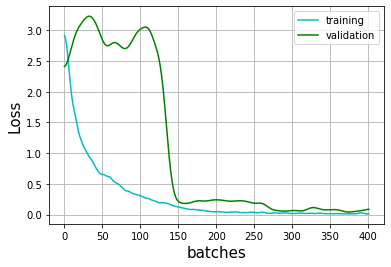

Time elapsed =  73.03355902299995  seconds


In [194]:
losses_c, val_losses_c = train_combined_model(3, model, optimizer_3, train_loader_smol, val_loader_smol)

In [0]:
y_true_c1, y_pred_c1 = confusion_matrix_finder(cellnet_1, val_loader_smol)
y_true_c2, y_pred_c2 = confusion_matrix_finder(cellnet_2, val_loader_smol)
y_true, y_pred = confusion_matrix_finder(model, val_loader_smol, combined = True)

In [0]:
def accuracy(confusion_matrix):

    confusion_matrix = np.array(confusion_matrix)
    corrects = np.trace(confusion_matrix)
    total = np.sum(confusion_matrix)
    acc = (corrects/total)*100
    return acc

In [151]:
print ("Accuracy of model 1 = ", accuracy(confusion_matrix(y_true_c1, y_pred_c1)), "%")
print ("Accuracy of model 2 = ", accuracy(confusion_matrix(y_true_c2, y_pred_c2)), "%")
print ("Accuracy of the combined model = ", accuracy(confusion_matrix(y_true, y_pred)), "%")

Accuracy of model 1 =  91.66666666666666 %
Accuracy of model 2 =  90.41666666666667 %
Accuracy of the combined model =  98.58333333333333 %


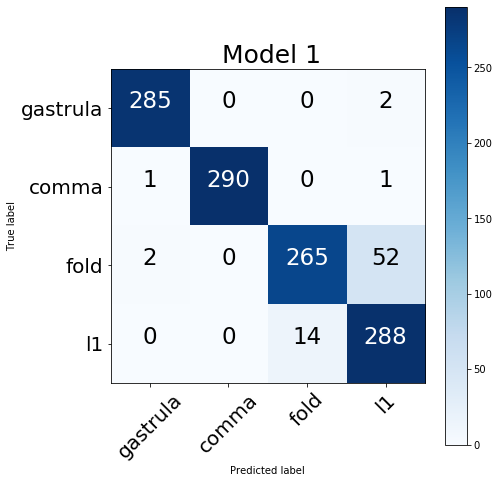

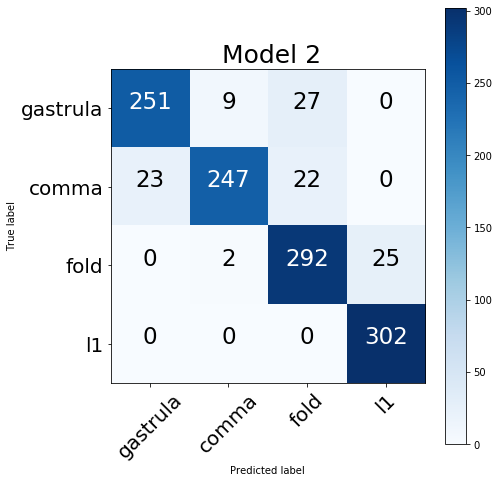

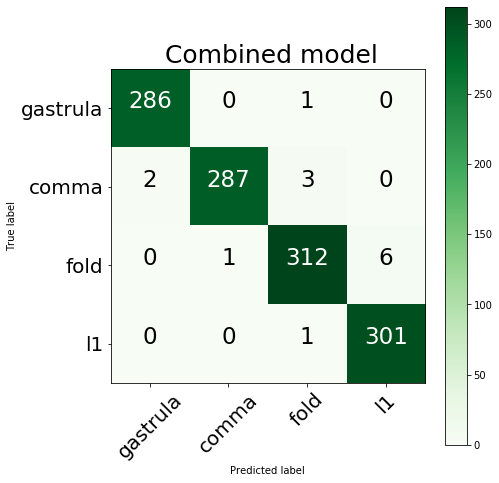

In [198]:
p1 = plot_confusion_matrix(confusion_matrix(y_true_c1, y_pred_c1), ("gastrula", "comma", "fold", "l1"), title = " Model 1")
p2 = plot_confusion_matrix(confusion_matrix(y_true_c2, y_pred_c2), ("gastrula", "comma", "fold", "l1"), title = " Model 2")
p3 = plot_confusion_matrix(confusion_matrix(y_true, y_pred), ("gastrula", "comma", "fold", "l1"), cmap = plt.cm.Greens, title = " Combined model")